In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

import scipy

from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import cage_utils
plt.rcParams['figure.figsize'] = [14, 10]

In [105]:
def asymTrapFilter(wf_in, rise, flat, fall):
    """ Computes an asymmetric trapezoidal filter"""
    wf_out = np.zeros(len(wf_in))
    wf_out[0] = wf_in[0]/float(rise)
    for i in range(1, rise):
        wf_out[i] = wf_out[i-1] + (wf_in[i])/float(rise)
    for i in range(rise, rise+flat):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise)
    for i in range(rise+flat, rise+flat+fall):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise) - wf_in[i-rise-flat]/float(fall)
    for i in range(rise+flat+fall, len(wf_in)):
        wf_out[i] = wf_out[i-1] + (wf_in[i] - wf_in[i-rise])/float(rise) - (wf_in[i-rise-flat] - wf_in[i-rise-flat-fall])/float(fall)
        
    return(wf_out)

In [129]:
def time_point_thresh(wf_in, threshold, tp_max):
    """
    Find the last timepoint before tp_max that wf_in crosses a threshold
     wf_in: input waveform
     threshold: threshold to search for
     tp_out: final time that waveform is less than threshold
    """
    for i in range(tp_max, 0, -1):
        if(wf_in[i]>threshold and wf_in[i-1]<threshold):
            tp_out = i
    return tp_out

In [2]:
f_superpulse = './data/normScan/run60_superpulses.hdf5'
f_pulser = './data/superpulses_oct2020.h5'

with pd.HDFStore(f_pulser, 'r') as f:
    print("Keys:", f.keys())
with pd.HDFStore(f_superpulse, 'r') as f:
    print("Keys:", f.keys())
    
data_superpulse = pd.read_hdf(f_superpulse, key = '/superpulses')
data_pulser = pd.read_hdf(f_pulser, key = '/superpulses')

Keys: ['/superpulses']
Keys: ['/superpulses']


In [3]:
data_pulser.head()

,V_pulser,run,E_keV,mV_firststage,index,unique_key,YYYY,mm,dd,cycle,...,dsp_file,dsp_path,hit_file,hit_path,startTime,threshold,daq_gb,stopTime,runtime,superpulse
0,0.16,838,60,13.2,836,cage-cyc838-2020107,2020,10,7,838,...,cage_run58_cyc838_dsp.lh5,/dsp,cage_run58_cyc838_hit.lh5,/hit,1.602109e+09,16.0,1.556451,1.602110e+09,9.997692,"[-0.00038934359960989353, 0.005904600270233672..."


In [19]:
pulser_super = data_pulser['superpulse'][0]
superpulse_60 = data_superpulse['pure_60'][0]
superpulse_60_notched = cage_utils.notchFilter_SIS3302(superpulse_60, Q=20)
pulser_super_notched = cage_utils.notchFilter_SIS3302(pulser_super, Q=20)

In [172]:
trap_super60 = asymTrapFilter(superpulse_60_notched, 2, 100, 400)
max_trap_60 = np.argmax(trap_super60)
tp_0_60 = time_point_thresh(trap_super60, 0.002, max_trap_60)
print(tp_0_60)

3956


(-0.01, 0.2)

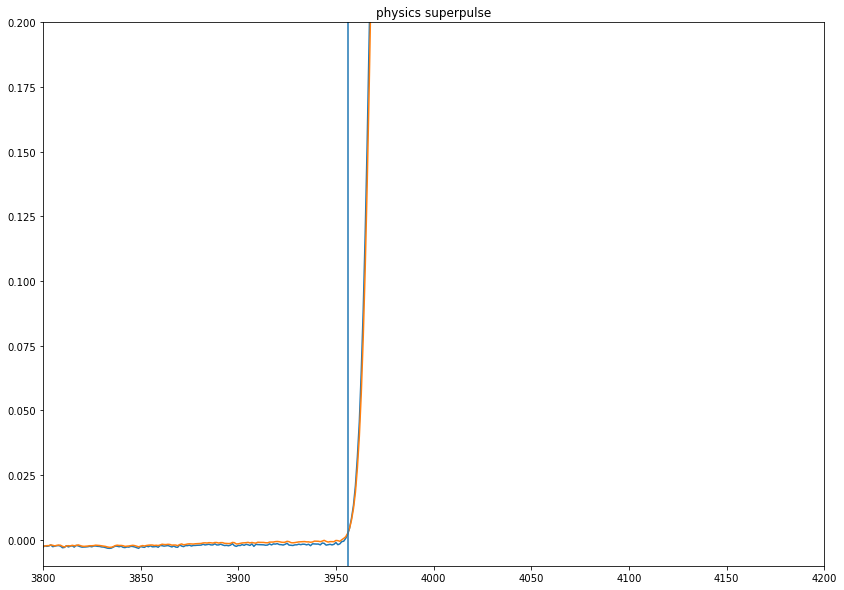

In [173]:
plt.plot(superpulse_60_notched[:-1] )
plt.plot(trap_super60[:-1])
plt.title('physics superpulse')
plt.axvline(tp_0_60)
plt.xlim(3800, 4200)
plt.ylim(-0.01, 0.2)

In [178]:
trap_pulser = asymTrapFilter(pulser_super_notched, 2, 100, 400)
max_trap_pulser = np.argmax(trap_pulser)
tp_0_pulser = time_point_thresh(trap_pulser, 0.004, max_trap_pulser)
print(tp_0_pulser)

3961


Text(0.5, 1.0, 'pulser superpulse')

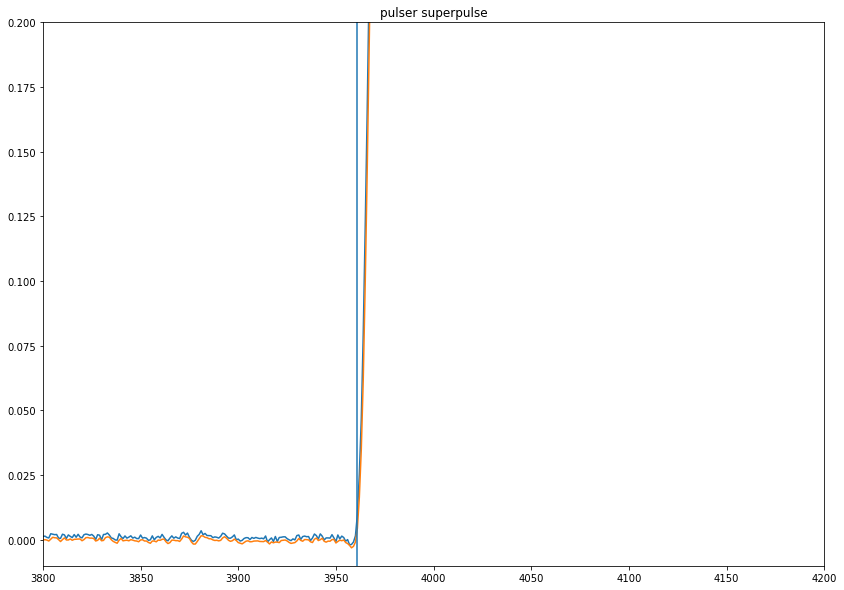

In [179]:
plt.plot(pulser_super_notched[:-1])
plt.plot(trap_pulser[:-1])
plt.axvline(tp_0_pulser)
plt.xlim(3800, 4200)
plt.ylim(-0.01, 0.2)
plt.title('pulser superpulse')

In [185]:
range(len(pulser_super_notched))

range(0, 8192)

In [192]:
# # pulser_super_notched_zeroed = [0.0 for ind in enumerate(pulser_super_notched) if int(ind)<tp_0_pulser]
# pulser_super_notched_zeroed = [0.0 for i in range(len(pulser_super_notched)) if i< tp_0_pulser]
# print(pulser_super_notched_zeroed)
pulser_super_notched_zeroed = pulser_super_notched

for i in range(len(pulser_super_notched)):
    if i < tp_0_pulser:
        pulser_super_notched_zeroed[i] = 0.0
        
print(pulser_super_notched_zeroed)

# (index, element) for index, element in enumerate(a_list)

[0.         0.         0.         ... 0.87217749 0.81113676 0.00095932]


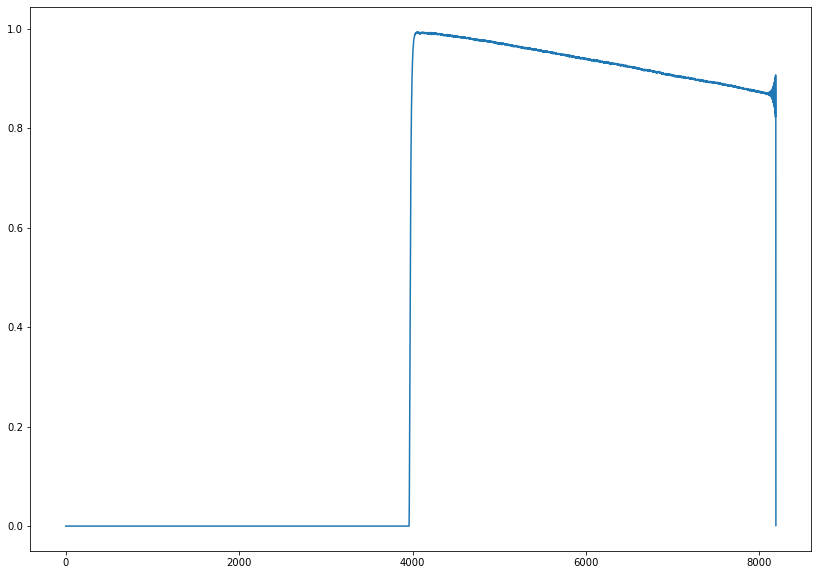

In [193]:
plt.plot(pulser_super_notched_zeroed)

In [222]:
delta = tp_0_pulser- tp_0_60
print(shift)

from scipy.ndimage.interpolation import shift

aligned_superpulse_60 = shift(superpulse_60_notched, delta-3, cval=0)
print(aligned_superpulse_60 )

<function shift at 0x2aaaecf44ee0>
[ 0.          0.         -0.00123273 ...  0.78757752  0.82023429
  0.78874434]


In [223]:
import numpy as np
from scipy.ndimage.interpolation import shift

array = np.array([ 1,2,3,4,5])

result = shift(array, 3, cval=0)
print(result)

[0 0 0 1 2]


In [224]:
fft_pulser = scipy.fft.fft(aligned_superpulse_60)#, norm='forward'
fft_60 = scipy.fft.fft(pulser_super_notched_zeroed)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'FFT of pulser superpulse')

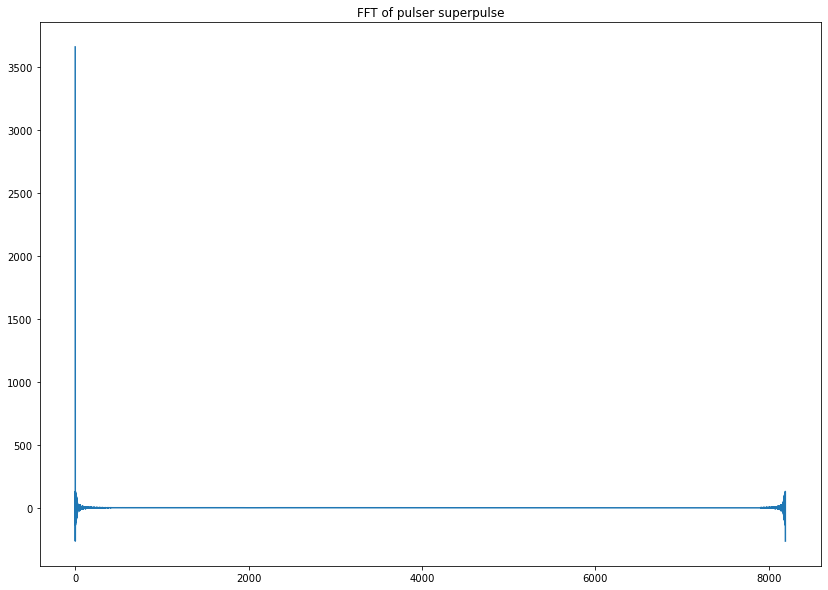

In [225]:
plt.plot(fft_pulser)
plt.title('FFT of pulser superpulse')

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'FFT of physics superpulse')

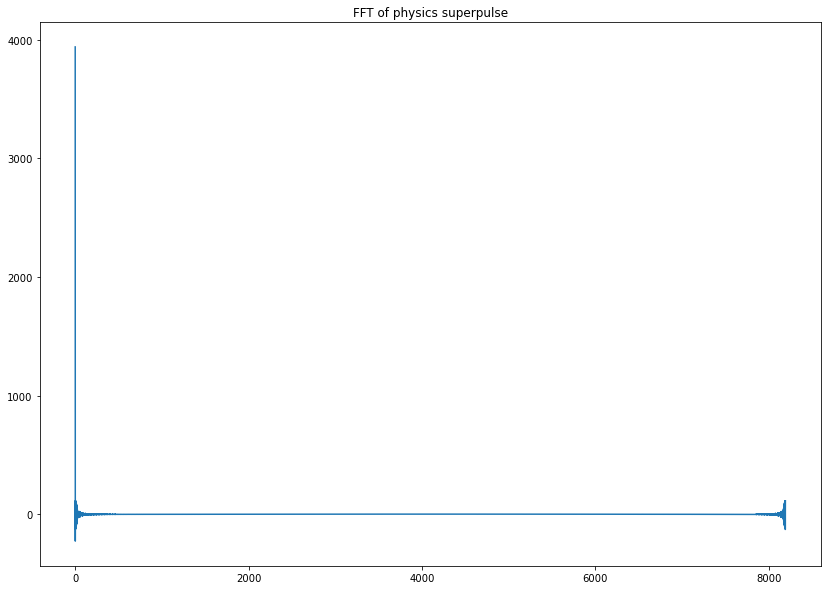

In [226]:
plt.plot(fft_60[:-1])
plt.title('FFT of physics superpulse')

In [227]:
deconvo_fft = np.divide(fft_60, fft_pulser)
deconvo = scipy.fft.ifft(deconvo_fft)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'FFT_physics/FFT_pulser')

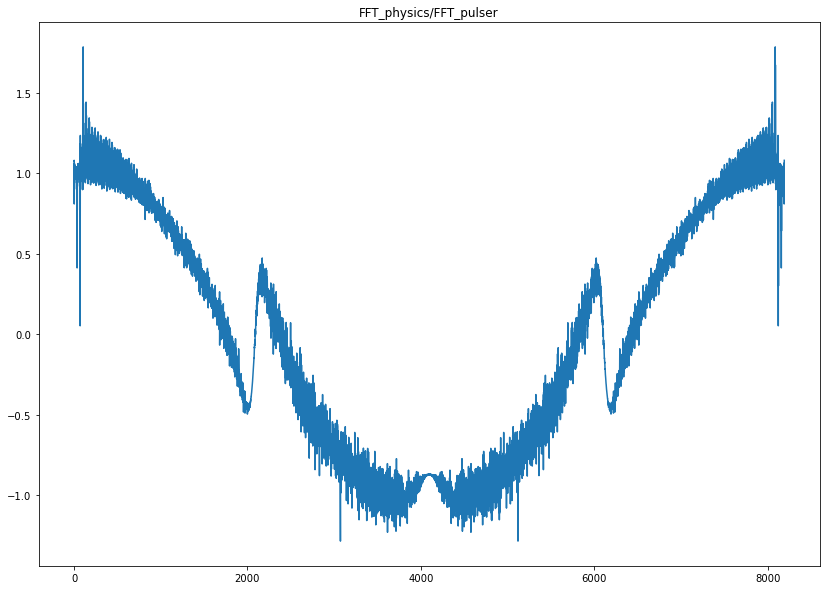

In [228]:
plt.plot(deconvo_fft)
plt.title('FFT_physics/FFT_pulser')

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'IFFT of FFT_physics/FFT_pulser')

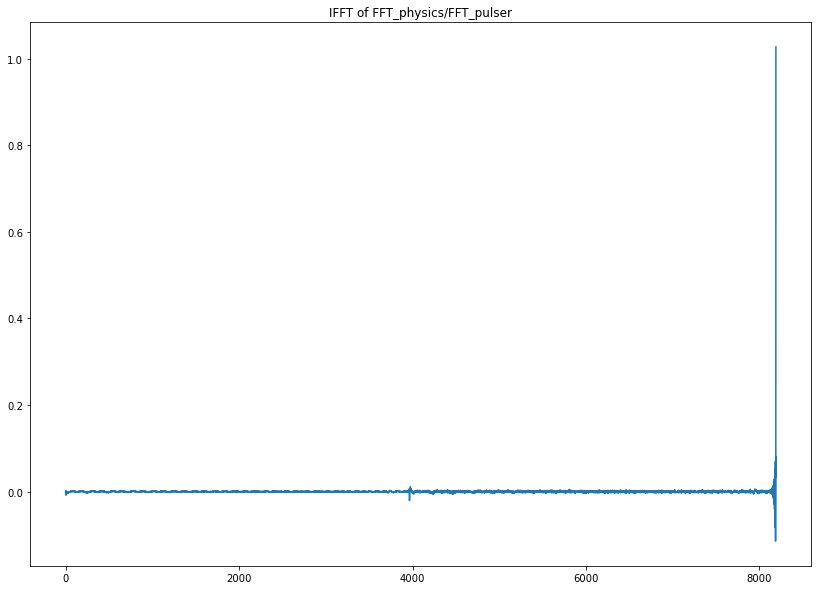

In [229]:
plt.plot(deconvo)
plt.title('IFFT of FFT_physics/FFT_pulser')

In [88]:
hmm = scipy.signal.deconvolve(superpulse_60_notched, pulser_super_notched)

In [91]:
print(hmm)

(array([1.31436146]), array([ 0.        , -0.00111655, -0.00077054, ..., -0.35761214,
       -0.33209796, -0.00140692]))


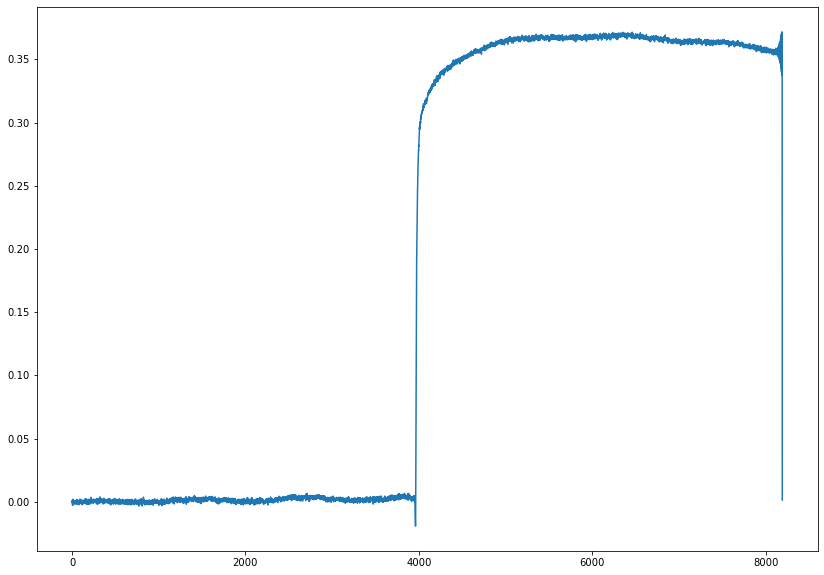

In [94]:
plt.plot(hmm[1]*-1)

In [14]:
print(len(pulser_super))

8192


In [ ]:
run = 60 #44 #70 #64
dsp_id = '02'
user = True
hit =True
cal = True
lowE=False
etype = 'trapEftp_cal'

corr_DCR=True
corr_AoE=True
corr_ToE=True

norm = True
cut = True


dsp_list = ['energy', 'trapEftp', 'trapEmax', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']

df_raw, dg, runtype, rt_min, radius, angle_det, rotary = cage_utils.getDataFrame(run, user=user, hit=hit, cal=cal, dsp_list=dsp_list, lowE=lowE)

df = cage_utils.apply_DC_Cuts(run, df_raw)

df_60 = df.query('trapEftp_cal > 55 and trapEftp_cal < 65').copy()


if corr_ToE==True:
    ToE_mode = cage_utils.mode_hist(df, param='ToE', a_bins=1000, alo=-0.1, ahi=0.45, cut=False, cut_str='')
    df['ToE_plot'] = df['ToE'] - ToE_mode
    df_60['ToE_plot'] = df_60['ToE'] - ToE_mode

In [ ]:
t, window_1_wfs = cage_utils.get_wfs(df_60, dg, cut_bkg_low, all=True)

In [ ]:
# fig, ax = plt.subplots(figsize=(9,8))
ax = plt.axes()

# set up colorbar to plot waveforms of different energies different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(window_1_wfs)))
c = np.arange(0, len(window_1_wfs))
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for n in range(len(window_1_wfs)):
    plt.plot(t, window_1_wfs[n][:len(window_1_wfs[n])-1], c=cmap.to_rgba(n))

# cb = fig.colorbar(cmap, ticks=(57.5, 59.5))
cb.set_label("Energy", ha = 'right', va='center', rotation=270, fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.text(0.95, 0.83, f'{cut_bkg_hi}', verticalalignment='top',
                        horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14,
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.title(f'run {run}: r = {radius} mm \ntheta = {angle_det} deg')

#     plt.xlim(3800, 8000)
#     plt.ylim(0.4, 1.01)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.title(f'60 keV waveforms for run {run}\nr = {radius} mm; theta = {angle_det} deg', fontsize=20)
plt.xlabel('clock cycles', fontsize=20)
# plt.xlim(3900, 4050)